**Project description**

Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.

**Goal**

Develop a model with the highest possible accuracy that will pick the right plan: Smart or Ultra.

**Data description** 

Every observation in the dataset contains monthly behavior information about one user. The information given is as follows:

- `сalls` — number of calls,
- `minutes` — total call duration in minutes,
- `messages` — number of text messages,
- `mb_used` — Internet traffic used in MB,
- `is_ultra` — plan for the current month (Ultra - 1, Smart - 0).

### Table of Contents

1. [Imports](#Imports)
2. [Open and look through the data file](#open)
3. [Preprocessing data](#preprocessing)
4. [EDA](#eda)
5. [Split the source data into a training set, a validation set, and a test set](#split)
6. [Standard Scaling](#scaling)
7. [Models' hyperparameters tuning](#hyperparameters)
8. [Preliminary accuracy (baseline)](#baseline)
9. [Decision Tree](#dt)
10. [Random Forest](#rf)
11. [Logistic Regression](#lr)
12. [Model selection](#selection)
13. [Retrain the best tuned model on the whole training set and test it on the test set](#retrain)
14. [Final conclusions](#conclusions)

<a id= 'Imports'></a>

**Imports**

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

pd.set_option('display.max_rows', None)

<a id= 'open'></a>

## Open and look through the data file

In [2]:
LOCAL_PATH = 'C:/Users/anna/Desktop/DS Yandex/ML Project/Project/users_behavior.csv'
PLATFORM_PATH = 'datasets/users_behavior.csv'
try:
    df = pd.read_csv(LOCAL_PATH)
except:
    df = pd.read_csv(PLATFORM_PATH)

# Print the table    
df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


> **Conclusions:**
- In table we see a target variable `is_ultra` and it is binary,
- Data types are valid, no need to change them,
- No NULLs or missed values,
- the features seems to be normally distributed, as their mean an median values are close to each other,
- for `messages` data looks skewed as we see lowest value at 25%.

<a id= 'preprocessing'></a>

**Preprocessing data**

Cheking for dublicates

In [5]:
print('There are {} dublicated values in users behavior  data.'.format(df.duplicated().sum()))

There are 0 dublicated values in users behavior  data.


<a id= 'eda'></a>

**Exploratory data analysis**

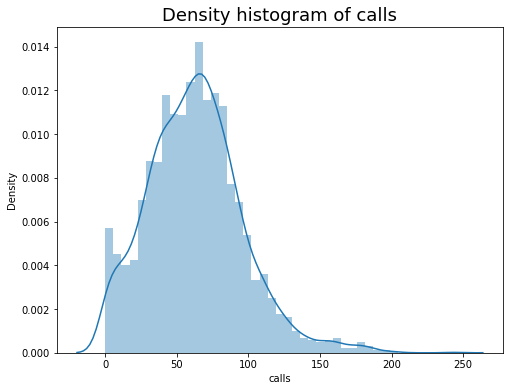

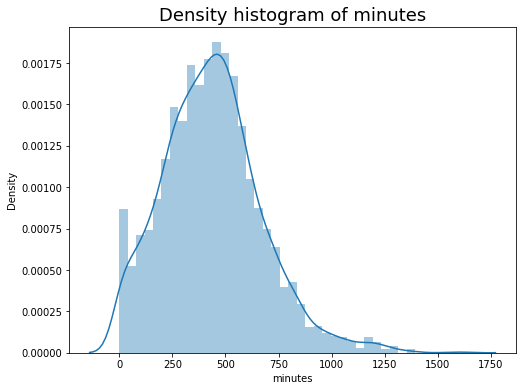

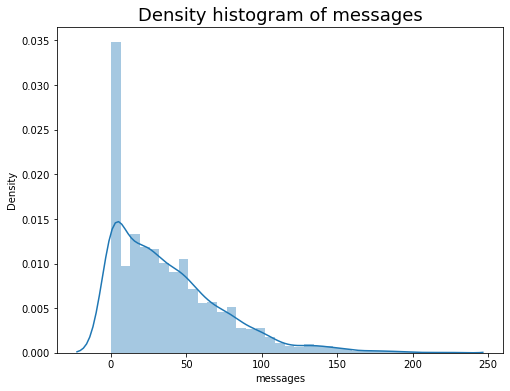

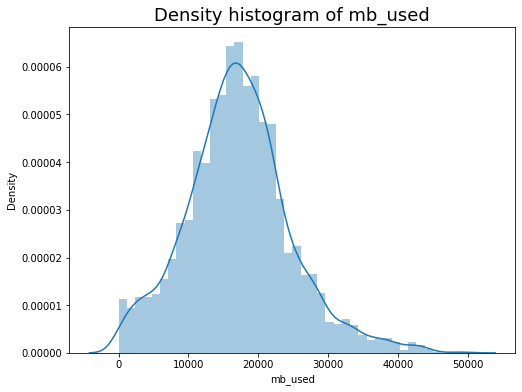

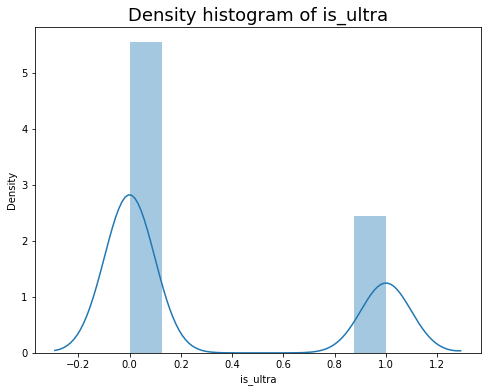

In [6]:
for i, col in enumerate(df.columns):
        plt.figure(i, figsize=(8,6))
        sns.distplot(df[col])
        plt.title("Density histogram of " + df.columns[i], fontsize=18)
        plt.ylabel('Density', fontsize=10)
        plt.show()

Lets check if 2 calsses in our tagret varialbe are balanced

In [7]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

>**Conclusions**:
- The parameters looks normally distributed, without significant outliers. `messages` shows right skeweness.
- Most clients are using plan "Smart"
- Two classes in targer variable are not balanced. We see that users of plan "Smart" are more than twice more than users of plan "Ultra".
- Imbalanced classifications are those where the number of observations belonging to one class is significantly lower than those belong to the other class. It comes problem when we try to predict lower ratio class. In general, Machine learning algorithms are designed to improve accuracy by reducing the error. However, when we build model to predict lower number of class, It will go fail and doesn't predict that class. [follow link](https://medium.com/@cmukesh8688/how-to-handle-imbalanced-classification-problems-4a96f42ae4c4)
- There're list of solution for [handling imbalanced datasets in machine learning](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28). I'll come back to them later, in case if after creating a model, I'll see that it has issues with prediction accuracy.

<a id= 'split'></a>

<a id= 'split'></a>

## Split the source data into a training set, a validation set, and a test set

First I'll split the data into a training and test sets with 80/20 proportion.

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split().

I'll use the stratified sampling as it has some advanteges: 
- Stratified random sampling accurately reflects the population being studied.
- It ensures each subgroup within the population receives proper representation within the sample.
- As a result, stratified random sampling provides better coverage of the population.
More information [here](https://medium.com/analytics-vidhya/stratified-sampling-in-machine-learning-f5112b5b9cfe)

In [8]:
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=12345)

Split data into training and validation set 20/80

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=12345)

In [10]:
X_test.name = 'X_test'
X_valid.name = 'X_valid'
y_train.name = 'y_train'
y_valid.name = 'y_valid'
y_test.name = 'y_test'
X_train.name = 'X_train'

Let's check the size of our sets

In [11]:
for parameter in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    print("Size of", parameter.name, ":", parameter.shape)

Size of X_train : (2056, 4)
Size of y_train : (2056,)
Size of X_valid : (515, 4)
Size of y_valid : (515,)
Size of X_test : (643, 4)
Size of y_test : (643,)


<a id= 'scaling'></a>

**Feature Scaling**

- One of the most important transformations we need to apply to the data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.

- There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

- Min-max scaling (normalization) is the simplest: values are shifted and rescaled so that they end up ranging from 0 to 1.

- Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range. Standardization is much less affected by outliers.

- I'll go with Standardization for my model

More about feature scaling in Machine Learning [here](https://contactsunny.medium.com/why-do-we-need-feature-scaling-in-machine-learning-and-how-to-do-it-using-scikit-learn-d8314206fe73)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

<a id= 'hyperparameters'></a>

**Models' hyperparameters tuning**

In addition to regular model parameters, we have hyperparameters. Hyperparameters help to improve the model. They can be tuned before training.

In this section we are going to figure out the best hyperparameters for each of the 3 learning algorithms:

- Decision Tree
- Random Forest
- Logistic Regression

The most important hyperparameter of the decision tree is max_depth. It determines what we will end up with — a stump with one question or a maple with huge crown.

<a id= 'baseline'></a>

Let's calculate preliminary accuracy (baseline)

In [13]:
main_class = y_train.mode()[0]
print("The most frequent plan is", main_class)

y_prelim_pred = np.full(shape=y_train.shape, fill_value=main_class)
accuracy_score(y_train, y_prelim_pred)

The most frequent plan is 0


0.6882295719844358

- It means that we can make a preliminary estimate of 68.82% chance of a random plan from this dataset to be "Smart". 
- This number will be a baseline for future models predictions, meaning that a model needs to have accuracy higher than the baseline to be selected.

<a id= 'dt'></a>

**Decision Tree**

Default model accuracy:

In [14]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_valid)

acc_decision_tree = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_decision_tree

68.74

In [15]:
for depth in range(1,11):
    decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_valid)
    acc_decision_tree = round(accuracy_score(y_valid,y_pred) * 100, 2)
    print("max_depth =", depth, ":", acc_decision_tree)

max_depth = 1 : 78.25
max_depth = 2 : 78.25
max_depth = 3 : 77.67
max_depth = 4 : 78.06
max_depth = 5 : 77.67
max_depth = 6 : 79.22
max_depth = 7 : 79.03
max_depth = 8 : 79.03
max_depth = 9 : 77.86
max_depth = 10 : 77.28


Tuned model accuracy:

In [16]:
decision_tree = DecisionTreeClassifier(random_state=12345, max_depth=6)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_valid)

acc_decision_tree = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_decision_tree

79.22

<a id= 'rf'></a>

**Random Forest**

Default model accuracy:

In [17]:
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_valid)

acc_rfc = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_rfc

78.45

In [18]:
d = []
for estim in range(1,51,9):
    for depth in range(1,10):
        rfc = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_valid)
        acc_rfc = round(accuracy_score(y_valid,y_pred) * 100, 2)
        d.append(
            {
                'n_estimators': estim,
                'max_depth': depth,
                'acc_rfc':  acc_rfc
            }
        )

best_param = pd.DataFrame(d).nlargest(1, ['acc_rfc'], keep='first')

Tuned model accuracy:

In [19]:
rfc = RandomForestClassifier(n_estimators = best_param['n_estimators'].values[0], max_depth = best_param['max_depth'].values[0], random_state=12345)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_valid)

acc_rfc = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_rfc

79.81

<a id= 'lr'></a>

**Logistic Regression**

Default model accuracy:

In [20]:
LR = LogisticRegression()
LR.fit(X_train, y_train)     
y_pred = LR.predict(X_valid)

acc_LR = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_LR

75.92

In [21]:
for c in [x / 100.0 for x in range(1, 100, 10)]:
    LR = LogisticRegression(random_state=12345, C=c)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_valid)
    acc_LR = round(accuracy_score(y_valid,y_pred) * 100, 2)
    print("c =", c, ":", acc_LR)

c = 0.01 : 76.31
c = 0.11 : 75.92
c = 0.21 : 75.92
c = 0.31 : 75.92
c = 0.41 : 75.92
c = 0.51 : 75.92
c = 0.61 : 75.92
c = 0.71 : 75.92
c = 0.81 : 75.92
c = 0.91 : 75.92


In [22]:
LR = LogisticRegression(solver="liblinear", multi_class="ovr", max_iter=200, class_weight={0:0.6, 1:0.4}, tol=0.05, random_state=12345)
LR.fit(X_train, y_train)     
y_pred = LR.predict(X_valid)

acc_LR = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_LR

76.89

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the correlation coefficient of the features in the decision function.

Positive coefficients increase the odds of the response and thus increase the probability. Negative coefficients decrease the odds of the response and thus decrease the probability.

In [23]:
coeff_df = pd.DataFrame()
coeff_df['Feature'] = ['calls','minutes','messages','mb_used']
coeff_df["Correlation"] = pd.Series(LR.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
2,messages,0.392931
0,calls,0.321334
3,mb_used,0.319076
1,minutes,0.062745


We can see that all 4 coefficients are positive, which proves a positive correlation between the features and the target. The `minutes` variable has the lowest effect on the target, so it can probably be even dropped. The other 3 features have similar effects on the target.

<a id= 'selection'></a>

## Model selection

In [24]:
models = pd.DataFrame({
    'Model': ['Decision Tree','Random Forest','Logistic Regression'],
    'Score': [acc_decision_tree, acc_rfc, acc_LR]})
sorted_by_score = models.sort_values(by='Score', ascending=False)

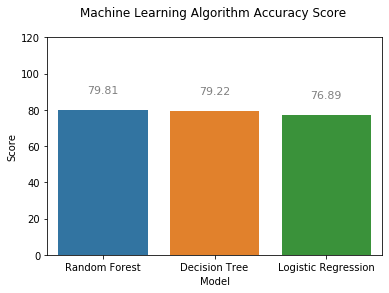

In [25]:
plt.title('Machine Learning Algorithm Accuracy Score')

g=sns.barplot(x='Model', y = 'Score', data = sorted_by_score)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                textcoords='offset points')
_ = g.set_ylim(0,120) #To make space for the annotations

<a id= 'retrain'></a>

**Retrain the best tuned model on the whole training set and test it on the test set**

In [26]:
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=12345)

In [27]:
rfc = RandomForestClassifier(n_estimators =10, max_depth=9, random_state=12345)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

acc_rfc = round(accuracy_score(y_test,y_pred) * 100, 2)
acc_rfc

81.34

**Sanity check**

The final accuracy of our model is on 12.5% higher than the baseline accuracy 68.82% that we would get if instead of classifying we simply predicted majority class target value for each new observation.

<a id= 'conclusion'></a>

> ## **Conclusion**

- In this project I have developed a binary classification model that analyzes subscribers' behavior and recommends one of the plans: Smart or Ultra.


- I've investigated the data by performing the descriptive statistics. I didn't find any missing or duplicated values. The number of outliers was not significant. I decided to keep the data as is and if necessary revisit this section after modeling or outliers.


- I have performed an exploratory data analysis and reached the following conclusions:


- Most features' distribution are close to normal, there is only slight deviation from it (except for messages). I corrected this by applying standard scaling before modeling.


- I noticed that our target classes are imbalanced: there are at least twice as many observations for the "Smart" than for the "Ultra" plan. Imbalanced classifications it is a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. I corrected this issue in the later sections by using the stratify parameter. It made a split so that the proportion of values in the sample produced would be the same as the proportion of values in the target variable.


- In the next step I tuned 3 learning algorithms to achieve the highest possible validation accuracy and thus select the best model. Random Forest model showed the highest score (76.89). Then I retrained this model on the whole training set (including validation set) and tested it with the test set that our model didn't see before. We have reached 81.34% accuracy on the test set.


- Finally, I checked the model for sanity by comparing the final score to the baseline accuracy. The final accuracy of the model is much higher (12.5%) than the baseline accuracy that we would get if instead of classifying we simply predicted majority class target value for each new observation.